In [1]:
import cv2
import matplotlib.pyplot as plt 
import numpy as np

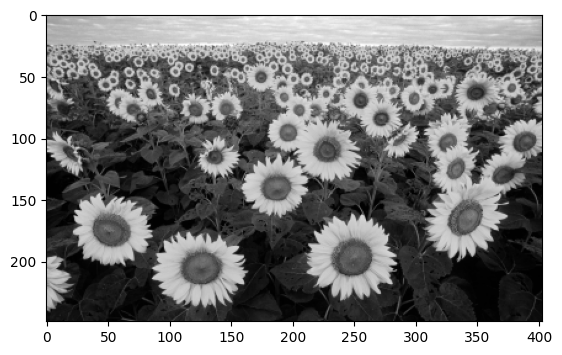

In [2]:
img = cv2.imread("images/sunflowers.jpg", flags=cv2.IMREAD_GRAYSCALE)

# Downsize image by factor of 8
height, width = img.shape
new_height, new_width = height // 8, width // 8
img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX) # Normalize the image to 0-255
plt.imshow(img,cmap='gray')

In [3]:
# DEFINE PARAMETERS (Copied from Lowe's paper)
num_octaves = 4
s = 3 # number of intervals per octave
sigma_init = 1.6 # initial sigma
k = 2**(1/s) # sigma multiplier

# Initial blur of the image
img_blur = cv2.GaussianBlur(img, (0,0), sigma_init)

In [4]:
# Precompute incremental sigmas similar to OpenCV
sigmas = [sigma_init]
for i in range(1, s + 3):
    sig_prev = sigma_init * (k ** (i - 1))
    sig_total = sig_prev * k
    sigmas.append((sig_total**2 - sig_prev**2) ** 0.5)

gaussian_pyramid = [[] for _ in range(num_octaves)]
gaussian_pyramid[0].append(img_blur)  # base image

for octave in range(num_octaves):
    if octave > 0:
        # Downsample the last blurred image from previous octave (index s)
        img_prev_oct = gaussian_pyramid[octave - 1][s]
        img_down = cv2.resize(img_prev_oct, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
        gaussian_pyramid[octave].append(img_down)
        img_blur = img_down

    for i in range(1, s + 3):
        img_blur = cv2.GaussianBlur(img_blur, (0, 0), sigmas[i])
        gaussian_pyramid[octave].append(img_blur)


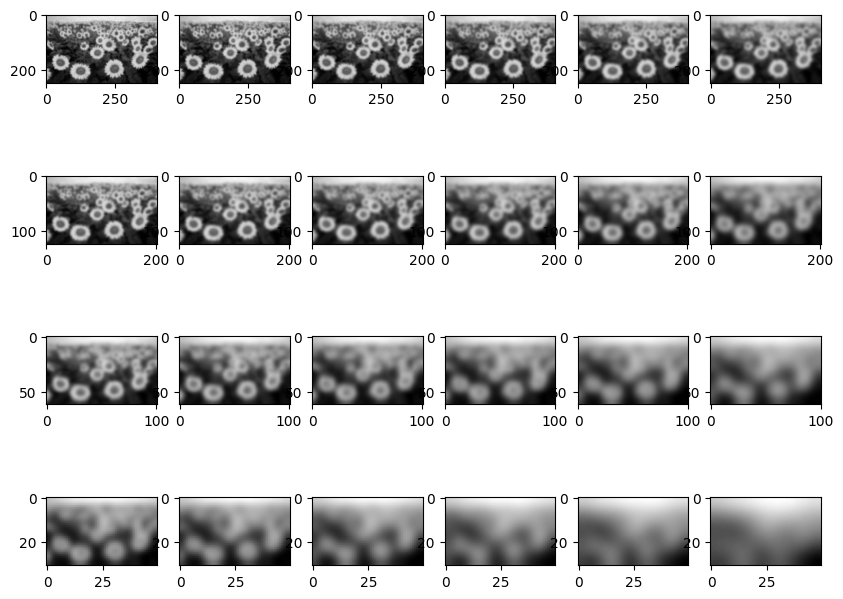

In [5]:
# Plot DoG pyramid
fig, axes = plt.subplots(num_octaves, s + 3, figsize=(2*(s + 2), 2*num_octaves))

for octave_idx, octave_images in enumerate(gaussian_pyramid):
    for img_idx, img in enumerate(octave_images):
        ax = axes[octave_idx, img_idx]
        ax.imshow(img, cmap='gray')

In [6]:
# Compute DoG pyramid
dog_pyramid = [[] for _ in range(num_octaves)]

for octave in range(num_octaves):
    for i in range(s + 2):
        if i == 0:
            # First DoG image is the difference between the first two blurred images
            dog_pyramid[octave].append(gaussian_pyramid[octave][i+1] - gaussian_pyramid[octave][i])
        else:
            # Subsequent DoG images are differences between consecutive blurred images
            dog_pyramid[octave].append(gaussian_pyramid[octave][i+1] - gaussian_pyramid[octave][i-1])



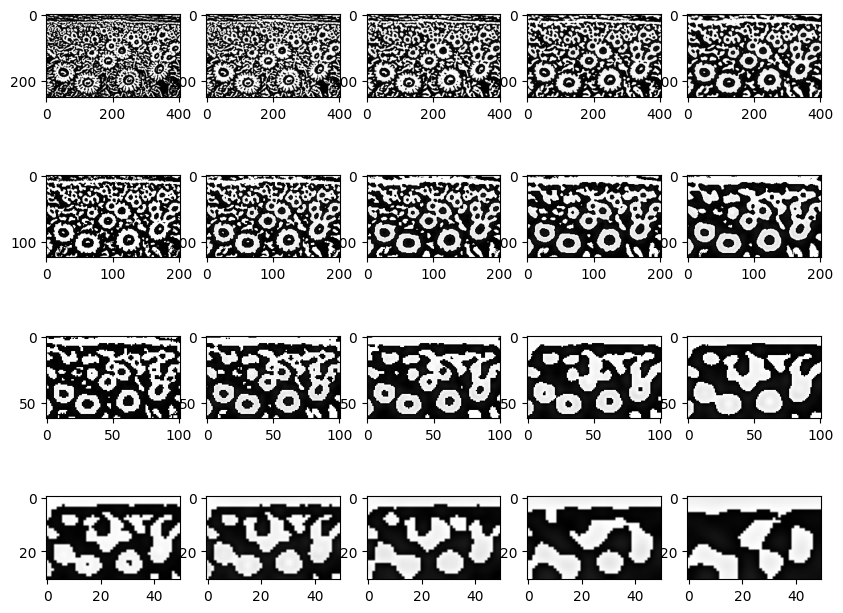

In [7]:
# Plot DoG pyramid
fig, axes = plt.subplots(num_octaves, s + 2, figsize=(2*(s + 2), 2*num_octaves))

for octave_idx, octave_images in enumerate(dog_pyramid):
    for img_idx, img in enumerate(octave_images):
        ax = axes[octave_idx, img_idx]
        ax.imshow(img, cmap='gray')

In [8]:
# Get keypoints (Local extrema)
keypoints = []

for octave in range(num_octaves):
    for img in range(s + 2):
        print(octave,img)
        for (i,j) in np.ndindex(dog_pyramid[octave][img].shape):
            if i == 0 or i == dog_pyramid[octave][img].shape[0] - 1 or j == 0 or j == dog_pyramid[octave][img].shape[1] - 1:
                continue # Skip the edges
            # Get the values of the 26 neighbors of the pixel
            neighbors_at_level = [] # 8 neighbors at the same level
            neighbors_at_level.append(dog_pyramid[octave][img][i, j+1])
            neighbors_at_level.append(dog_pyramid[octave][img][i, j-1])
            neighbors_at_level.append(dog_pyramid[octave][img][i+1, j])
            neighbors_at_level.append(dog_pyramid[octave][img][i-1, j])
            neighbors_at_level.append(dog_pyramid[octave][img][i+1, j+1])
            neighbors_at_level.append(dog_pyramid[octave][img][i-1, j-1])
            neighbors_at_level.append(dog_pyramid[octave][img][i+1, j-1])
            neighbors_at_level.append(dog_pyramid[octave][img][i-1, j+1])
            

            neighbors_above = [] # 9 neighbors above
            if img <  s + 1: # Check if there is an image above
                neighbors_above.append(dog_pyramid[octave][img + 1][i, j])
                neighbors_above.append(dog_pyramid[octave][img + 1][i, j+1])
                neighbors_above.append(dog_pyramid[octave][img + 1][i, j-1])
                neighbors_above.append(dog_pyramid[octave][img + 1][i+1, j])
                neighbors_above.append(dog_pyramid[octave][img + 1][i-1, j])
                neighbors_above.append(dog_pyramid[octave][img + 1][i+1, j+1])
                neighbors_above.append(dog_pyramid[octave][img + 1][i-1, j-1])
                neighbors_above.append(dog_pyramid[octave][img + 1][i+1, j-1])
                neighbors_above.append(dog_pyramid[octave][img + 1][i-1, j+1])
        
            neighbors_below = [] # 9 neighbors below
            if octave > 0: # Check if there is an octave below
                neighbors_below.append(dog_pyramid[octave][img - 1][i, j])
                neighbors_below.append(dog_pyramid[octave][img - 1][i, j+1])
                neighbors_below.append(dog_pyramid[octave][img - 1][i, j-1])
                neighbors_below.append(dog_pyramid[octave][img - 1][i+1, j])
                neighbors_below.append(dog_pyramid[octave][img - 1][i-1, j])
                neighbors_below.append(dog_pyramid[octave][img - 1][i+1, j+1])
                neighbors_below.append(dog_pyramid[octave][img - 1][i-1, j-1])
                neighbors_below.append(dog_pyramid[octave][img - 1][i+1, j-1])
                neighbors_below.append(dog_pyramid[octave][img - 1][i-1, j+1])                

            # Concat  all neighbors
            neighbors = np.concatenate([neighbors_at_level, neighbors_above, neighbors_below])

            # Check if the pixel is a local extremum
            if dog_pyramid[octave][img][i, j] > np.max(neighbors) or dog_pyramid[octave][img][i, j] < np.min(neighbors):
                keypoints.append((octave, img, i, j))


print(len(keypoints))

           



0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
12140
